In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fgvc-aircraft/val.csv
/kaggle/input/fgvc-aircraft/train.csv
/kaggle/input/fgvc-aircraft/test.csv
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/example_evaluation.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/vl_pr.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/evaluation.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/README.md
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/vl_roc.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/vl_argparse.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/README.html
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/vl_tpfp.m
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_manufacturer_train.txt
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_variant_val.txt
/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/f

In [2]:
import pandas as pd
import numpy as np
import os

#  Base path
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"

#  Load mapping files
def load_mapping(file_path, label_type):
    mapping = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                mapping.append((parts[0], parts[1]))
    return pd.DataFrame(mapping, columns=["image", label_type])

variant_df = load_mapping(f"{base_path}/images_variant_trainval.txt", "variant")
family_df = load_mapping(f"{base_path}/images_family_trainval.txt", "family")
maker_df = load_mapping(f"{base_path}/images_manufacturer_trainval.txt", "maker")

#  Merge labels on 'image'
df = variant_df.merge(family_df, on="image").merge(maker_df, on="image")

#  Group by variant to get canonical family & maker
hierarchy = df.groupby("variant")[["family", "maker"]].agg(lambda x: x.mode().iloc[0]).reset_index()

#  Create ID maps
variant_to_id = {v: i for i, v in enumerate(hierarchy["variant"].sort_values().unique())}
family_to_id = {f: i for i, f in enumerate(hierarchy["family"].sort_values().unique())}
maker_to_id = {m: i for i, m in enumerate(hierarchy["maker"].sort_values().unique())}

#  Map IDs
hierarchy["variant_id"] = hierarchy["variant"].map(variant_to_id)
hierarchy["family_id"] = hierarchy["family"].map(family_to_id)
hierarchy["maker_id"] = hierarchy["maker"].map(maker_to_id)

#  Optional: Create lookup dicts for later use
variant_to_family = hierarchy.set_index("variant_id")["family_id"].to_dict()
variant_to_maker = hierarchy.set_index("variant_id")["maker_id"].to_dict()

#  Save CSV
output_path = "/kaggle/working/hierarchy_full.csv"
hierarchy.to_csv(output_path, index=False)

#  Confirm
print(" hierarchy_full.csv saved with columns:", hierarchy.columns.tolist())
print(f" Classes: {len(variant_to_id)} variants, {len(family_to_id)} families, {len(maker_to_id)} makers")


 hierarchy_full.csv saved with columns: ['variant', 'family', 'maker', 'variant_id', 'family_id', 'maker_id']
 Classes: 100 variants, 70 families, 30 makers


In [3]:
#  Step 1: Prepare variant to family/maker hierarchy and task splits
import pandas as pd
import os
import random
import json

# Path to original FGVC Aircraft data
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"

# Load mapping from original trainval files
def load_mapping(file_path, label_type):
    mapping = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                mapping.append((parts[0], parts[1]))
    return pd.DataFrame(mapping, columns=["image", label_type])

variant_df = load_mapping(f"{base_path}/images_variant_trainval.txt", "variant")
family_df = load_mapping(f"{base_path}/images_family_trainval.txt", "family")
maker_df = load_mapping(f"{base_path}/images_manufacturer_trainval.txt", "maker")

# Merge into a full image-level dataframe
df = variant_df.merge(family_df, on="image").merge(maker_df, on="image")

# Get the variant-level hierarchy (unique mapping assumed)
hierarchy = df.groupby("variant")[["family", "maker"]].agg(lambda x: x.mode()[0]).reset_index()

# Save the full hierarchy
hierarchy_path = "/kaggle/working/hierarchy_full.csv"
hierarchy.to_csv(hierarchy_path, index=False)

#  Step 2: Split variants into 10 tasks randomly
variants = hierarchy["variant"].tolist()
random.seed(42)
random.shuffle(variants)

num_tasks = 20
variants_per_task = len(variants) // num_tasks

# Build task split dictionary with full hierarchy per variant
task_hierarchy = {}
for i in range(num_tasks):
    task_name = f"task_{i+1}"
    task_variants = variants[i*variants_per_task:(i+1)*variants_per_task]
    task_data = []
    for var in task_variants:
        fam = hierarchy[hierarchy["variant"] == var].iloc[0]["family"]
        mak = hierarchy[hierarchy["variant"] == var].iloc[0]["maker"]
        task_data.append({"variant": var, "family": fam, "manufacturer": mak})
    task_hierarchy[task_name] = task_data

# Save task split to JSON
with open("/kaggle/working/task_split.json", "w") as f:
    json.dump(task_hierarchy, f, indent=4)

print(" Task split with hierarchy saved to task_split.json")


 Task split with hierarchy saved to task_split.json


In [4]:
import os
import json
import torch
from PIL import Image
import numpy as np
from skimage.segmentation import slic
from skimage.util import img_as_float
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tqdm import tqdm

#  Paths
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"
img_dir = os.path.join(base_path, "images")
seg_dir = "/kaggle/working/segment_maps"
mapping_file = "/kaggle/working/mapping.txt"
task_split_path = "/kaggle/working/task_split.json"
variant_label_file = os.path.join(base_path, "images_variant_trainval.txt")

#  Create output directory
os.makedirs(seg_dir, exist_ok=True)
mapping = []

#  Step 1: Load task split
with open(task_split_path, "r") as f:
    task_split = json.load(f)

#  Step 2: Get list of allowed variants from all tasks
all_variants = set()
for task_data in task_split.values():
    for entry in task_data:
        all_variants.add(entry["variant"])

#  Step 3: Safe parser for image → variant mapping
def load_variant_mapping(file_path):
    records = []
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                image, variant = parts
                records.append((image, variant))
    return pd.DataFrame(records, columns=["image", "variant"])

variant_df = load_variant_mapping(variant_label_file)
variant_df = variant_df[variant_df["variant"].isin(all_variants)].drop_duplicates().sort_values("image")

#  Step 4: Generate segment maps only for selected images
print(f" Generating superpixel maps for {len(variant_df)} images in task variant split...")

skipped = 0

for _, row in tqdm(variant_df.iterrows(), total=len(variant_df)):
    image_id = row["image"]
    img_path = os.path.join(img_dir, f"{image_id}.jpg")
    
    if not os.path.exists(img_path):
        skipped += 1
        continue

    try:
        image = Image.open(img_path).convert("RGB")
        resized = image.resize((224, 224))
        image_np = img_as_float(np.array(resized))

        segments = slic(image_np, n_segments=196, compactness=10, start_label=0)
        flat = segments.flatten()
        encoder = LabelEncoder()
        encoded = encoder.fit_transform(flat)
        normalized_segments = encoded.reshape(224, 224)

        seg_tensor = torch.from_numpy(normalized_segments).long()
        seg_save_path = os.path.join(seg_dir, image_id + ".pt")
        torch.save(seg_tensor, seg_save_path)

        mapping.append(f"{image_id} segment_maps/{image_id}.pt")
    except Exception as e:
        print(f"⚠️ Skipping {image_id}: {e}")
        skipped += 1

#  Save mapping file
with open(mapping_file, "w") as f:
    f.writelines([line + "\n" for line in mapping])

#  Summary
print(f"\n Completed generation of superpixel maps.")
print(f" mapping.txt saved at {mapping_file}")
print(f"  Total segment maps created: {len(mapping)}")
print(f" Skipped or failed images: {skipped}")


 Generating superpixel maps for 6667 images in task variant split...


100%|██████████| 6667/6667 [09:46<00:00, 11.38it/s]


 Completed generation of superpixel maps.
 mapping.txt saved at /kaggle/working/mapping.txt
  Total segment maps created: 6667
 Skipped or failed images: 0


In [5]:
!mkdir -p cast_models


In [6]:
%%writefile cast_models/aircraft_dataset.py
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class AircraftHCASTDataset(Dataset):
    """
    Aircraft HCAST Dataset for Hierarchical Classification.
    Includes an optional flag to include segment maps or not.
    """
    def __init__(self, image_dir, label_file, image_split_file, mapping_file,
                 transform=None, use_segments=True, debug=False):
        self.image_dir = image_dir
        self.debug = debug
        self.use_segments = use_segments

        #  Default image transform
        self.transform = transform or T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
        #  Load hierarchy
        self.hierarchy_df = pd.read_csv(label_file)
        self.variant_map = {
            row["variant"].strip().lower(): (row["variant_id"], row["family_id"], row["maker_id"])
            for _, row in self.hierarchy_df.iterrows()
        }
        self.num_variants = self.hierarchy_df["variant_id"].nunique()
        self.num_families = self.hierarchy_df["family_id"].nunique()
        self.num_makers = self.hierarchy_df["maker_id"].nunique()

        #  Segment path mapping
        if self.use_segments:
            with open(mapping_file, "r") as f:
                self.seg_dict = {
                    line.strip().split()[0]: line.strip().split()[1]
                    for line in f if line.strip()
                }

        #  Init sample storage
        self.samples = []
        self.variants = []
        self.families = []
        self.makers = []
        self.variant_names = []

        known_variants = set(self.variant_map.keys())

        with open(image_split_file, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                try:
                    base_name, variant = line.strip().split(" ", 1)
                except ValueError:
                    if self.debug:
                        print(f"⚠️ Malformed line: {line.strip()}")
                    continue

                variant_norm = variant.strip().lower()
                img_name = base_name + ".jpg"

                if variant_norm not in known_variants:
                    if self.debug:
                        print(f"❌ Unknown variant: {variant}")
                    continue

                # ✅ Segment file check only if use_segments is True
                seg_rel_path = None
                if self.use_segments:
                    if base_name not in self.seg_dict:
                        if self.debug:
                            print(f"❌ Missing segment map: {base_name}")
                        continue
                    seg_rel_path = self.seg_dict[base_name]
                    seg_abs_path = os.path.join("/kaggle/working", seg_rel_path)
                    if not os.path.exists(seg_abs_path):
                        if self.debug:
                            print(f"❌ Segment file missing: {seg_abs_path}")
                        continue

                variant_id, family_id, maker_id = self.variant_map[variant_norm]
                self.samples.append((img_name, variant_norm, seg_rel_path))
                self.variants.append(variant_id)
                self.families.append(family_id)
                self.makers.append(maker_id)
                self.variant_names.append(variant.strip())

        if self.debug:
            print(f" Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, variant_norm, seg_rel_path = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)

        #  Load image
        image = Image.open(img_path).convert("RGB")
        image_tensor = self.transform(image)

        #  Load segment map if enabled
        segment_map = None
        if self.use_segments:
            seg_path = os.path.join("/kaggle/working", seg_rel_path)
            segment_map = torch.load(seg_path)

        #  Hierarchical labels
        variant_id, family_id, maker_id = self.variant_map[variant_norm]

        return {
            "image": image_tensor,
            "segments": segment_map,
            "variant": torch.tensor(variant_id, dtype=torch.long),
            "family": torch.tensor(family_id, dtype=torch.long),
            "maker": torch.tensor(maker_id, dtype=torch.long),
            "image_name": img_name
        }


Writing cast_models/aircraft_dataset.py


In [7]:
%%writefile cast_models/cast.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import PatchEmbed, trunc_normal_

from cast_models.utils import segment_mean_nd
from cast_models.graph_pool import GraphPooling
from cast_models.modules import Pooling, ConvStem

__all__ = ['cast_small', 'cast_small_deep', 'cast_base', 'cast_base_deep']

class DynamicHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.in_dim = in_dim
        self.num_classes = num_classes
        self.head = nn.Linear(in_dim, num_classes)

    def expand(self, num_new_classes):
        new_total = self.num_classes + num_new_classes
        device = self.head.weight.device
        new_head = nn.Linear(self.in_dim, new_total).to(device)
        with torch.no_grad():
            if self.num_classes > 0:
                new_head.weight[:self.num_classes] = self.head.weight
                new_head.bias[:self.num_classes] = self.head.bias
        self.head = new_head
        self.num_classes = new_total

    def forward(self, x):
        return self.head(x)

class CAST(VisionTransformer):
    def __init__(self, *args, **kwargs):
        nb_classes = kwargs.pop('nb_classes', None)
        init_num_classes = kwargs.pop('init_num_classes', 5)
        dropout_rate = kwargs.pop('dropout_rate', 0.1)
        assert nb_classes is not None, "You must provide nb_classes"

        depths = kwargs['depth']
        num_clusters = kwargs.pop('num_clusters', [64, 32, 16, 8])
        kwargs['depth'] = sum(depths)
        kwargs['drop_rate'] = dropout_rate
        kwargs['attn_drop_rate'] = dropout_rate
        kwargs['drop_path_rate'] = dropout_rate

        super().__init__(*args, **kwargs)

        if hasattr(self, 'dist_token'):
            del self.dist_token
        if hasattr(self, 'head_dist'):
            del self.head_dist

        if len(nb_classes) == 3:
            self.total_classes, self.num_family, self.num_manufacturer = nb_classes
        elif len(nb_classes) == 2:
            self.total_classes, self.num_family = nb_classes
            self.num_manufacturer = 0
        else:
            self.total_classes = nb_classes[0]
            self.num_family = 0
            self.num_manufacturer = 0

        # Start all heads at 0 for dynamic expansion
        self.head = DynamicHead(self.embed_dim, init_num_classes)
        self.family_head = DynamicHead(self.embed_dim, 0)
        self.manufacturer_head = DynamicHead(self.embed_dim, 0)

        patch_H, patch_W = self.patch_embed.grid_size
        num_patches = patch_H * patch_W
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))
        trunc_normal_(self.pos_embed, std=.02)

        cumsum = [0]
        for d in depths:
            cumsum.append(cumsum[-1] + d)
        assert sum(depths) == len(self.blocks)

        blocks, pools = [], []
        for i, d in enumerate(depths):
            blocks.append(self.blocks[cumsum[i]:cumsum[i + 1]])
            pool = Pooling(pool_block=GraphPooling(
                num_clusters=num_clusters[i],
                d_model=self.embed_dim,
                l2_normalize_for_fps=False
            ))
            if i == len(depths) - 1:
                for m in (pool.pool_block.fc1, pool.pool_block.fc2, pool.pool_block.centroid_fc):
                    for p in m.parameters():
                        p.requires_grad = False
            pools.append(pool)

        self.blocks1, self.pool1 = blocks[0], pools[0]
        self.blocks2, self.pool2 = blocks[1], pools[1]
        self.blocks3, self.pool3 = blocks[2], pools[2]
        self.blocks4, self.pool4 = blocks[3], pools[3]

    def _block_operations(self, x, cls_token, pad_mask, nn_block, pool_block, norm_block):
        cls_x = torch.cat([cls_token, x], dim=1)
        cls_x = nn_block(cls_x).type_as(x)
        cls_token, x = cls_x[:, :1], cls_x[:, 1:]

        cls_token, logit, centroid, new_mask, inds = pool_block(cls_token, x, pad_mask)
        out = norm_block(cls_x)[:, 0] if norm_block else cls_x[:, 0]
        return x, cls_token, logit, centroid, new_mask, inds, out

    def forward_features(self, x, y):
        x = self.patch_embed(x)
        N, H, W, C = x.shape
        y = F.interpolate(y.unsqueeze(1).float(), (H, W), mode='nearest').squeeze(1).long()
        ones = torch.ones((N, H, W, 1), device=x.device)
        avg = segment_mean_nd(ones, y).squeeze(-1)
        pad = avg <= 0.5
        x = segment_mean_nd(x, y)
        pos = segment_mean_nd(
            self.pos_embed[:, 1:].view(1, H, W, C).expand(N, -1, -1, -1), y
        )
        x = self.pos_drop(x + pos)
        cls = self.cls_token.expand(N, -1, -1) + self.pos_embed[:, :1]

        x, cls1, _, cent1, pad1, _, _ = self._block_operations(x, cls, pad, self.blocks1, self.pool1, None)
        x, cls2, _, cent2, pad2, _, out2 = self._block_operations(cent1, cls1, pad1, self.blocks2, self.pool2, None)
        x, cls3, _, cent3, pad3, _, out3 = self._block_operations(cent2, cls2, pad2, self.blocks3, self.pool3, None)
        _, _, _, _, _, _, out4 = self._block_operations(cent3, cls3, pad3, self.blocks4, self.pool4, self.norm)

        return out2, out3, out4

    def forward(self, x, y):
        out2, out3, out4 = self.forward_features(x, y)
        logits = self.head(out2)
        fam_logits = self.family_head(out3)
        man_logits = self.manufacturer_head(out4)
        return logits, fam_logits, man_logits

@register_model
def cast_small(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=384, num_clusters=[64, 32, 16, 8],
        depth=[3, 3, 3, 2], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def cast_small_deep(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=384, num_clusters=[64, 32, 16, 8],
        depth=[6, 3, 3, 3], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def cast_base(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=768, num_clusters=[64, 32, 16, 8],
        depth=[3, 3, 3, 2], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def cast_base_deep(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=768, num_clusters=[64, 32, 16, 8],
        depth=[6, 3, 3, 3], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model


Writing cast_models/cast.py


In [8]:
%%writefile cast_models/graph_pool.py

import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

from cast_models.utils import farthest_point_sampling
from cast_models.utils import segment_mean_nd


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim must be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):
    def __init__(self, dim, num_heads, qkv_bias=False, drop=0., attn_drop=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm = norm_layer(dim)
        self.attn = Attention(dim, num_heads, qkv_bias, attn_drop, drop)
        self.drop_path = nn.Identity()
        self.bias = nn.Parameter(torch.zeros(dim).normal_(0, 1e-2))

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm(x)))
        x = x - x.mean(dim=1, keepdim=True) + self.bias.view(1, 1, -1)
        return x


class GraphPooling(nn.Module):
    def __init__(
        self,
        num_clusters=4,
        d_model=512,
        dropout=0.1,
        l2_normalize_for_fps=True,
        num_heads=12,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    ):
        super().__init__()
        self._num_clusters = num_clusters
        self._l2_normalize_for_fps = l2_normalize_for_fps

        self.centroid_fc = Block(d_model, num_heads, qkv_bias, norm_layer=norm_layer)
        self.fc1 = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.fc2 = nn.Sequential(
            nn.LayerNorm(d_model * 4),
            nn.Linear(d_model * 4, d_model)
        )

    def _fill_with_mean(self, src, mask):
        bs, sl, cs = src.shape
        if mask is not None:
            mean_src = valid_mean(src, ~mask).unsqueeze(1).type_as(src)
            fill_mask = mask.unsqueeze(2).expand(-1, -1, cs)
            filled_src = torch.where(fill_mask, mean_src.expand(-1, sl, -1), src)
        else:
            mean_src = src.mean(dim=1, keepdim=True)
            filled_src = src
        return filled_src, mean_src

    def forward(self, cls_token, src, mask=None):
        bs, sl, cs = src.shape

        if sl < self._num_clusters:
            raise ValueError(f"Too few tokens ({sl}) to sample {self._num_clusters} clusters.")

        filled_src, mean_src = self._fill_with_mean(src, mask)
        padded_src = torch.cat([mean_src, filled_src], dim=1)

        sampling_src = F.normalize(padded_src, dim=-1) if self._l2_normalize_for_fps else padded_src
        sampled_inds = farthest_point_sampling(sampling_src, self._num_clusters).clamp(0, sl - 1)
        unfold_inds = sampled_inds.unsqueeze(2).expand(-1, -1, cs)

        node_features = self.centroid_fc(src)
        centroid_feats = torch.gather(node_features, 1, unfold_inds)

        norm_node = F.normalize(node_features, dim=-1)
        norm_centroid = F.normalize(centroid_feats, dim=-1)
        logits = torch.matmul(norm_node, norm_centroid.transpose(1, 2)) * 5
        assignments = torch.softmax(logits, dim=-1)

        fc1_cls_src = self.fc1(torch.cat([cls_token, src], dim=1))
        fc1_cls, fc1_src = fc1_cls_src[:, :1], fc1_cls_src[:, 1:]

        normalizer = assignments.transpose(1, 2) @ torch.ones((bs, sl, 1), dtype=src.dtype, device=src.device)
        centroid = assignments.transpose(1, 2) @ fc1_src
        centroid = centroid / (normalizer + 1e-6)

        fc2_out = self.fc2(torch.cat([fc1_cls, centroid], dim=1))
        new_cls = fc2_out[:, :1, :] + cls_token
        new_centroid = fc2_out[:, 1:, :] + torch.gather(src, 1, unfold_inds)

        out = new_cls.squeeze(1)  # Final graph representation
        new_mask = None  # Placeholder for hierarchy-aware masking

        return new_cls, logits, new_centroid, new_mask, sampled_inds, out


def valid_mean(x, mask):
    mask = mask.type_as(x).unsqueeze(2)  # [B, N, 1]
    sum_mask = torch.clamp(mask.sum(dim=1), min=1)
    masked_x = x * mask
    mean_x = masked_x.sum(dim=1) / sum_mask
    return mean_x


Writing cast_models/graph_pool.py


In [9]:
%%writefile cast_models/modules.py
"""Define shared modules"""
import torch
import torch.nn as nn

from timm.layers.helpers import to_2tuple


class Pooling(nn.Module):

    def __init__(self, pool_block):
        super(Pooling, self).__init__()
        self.pool_block = pool_block

    def forward(self, cls_token, x, padding_mask=None):
        cls_token, pool_logit, centroid, new_mask, sampled_x_inds, out = self.pool_block(cls_token=cls_token, src=x, mask=padding_mask)

        pool_padding_mask = torch.zeros(
            (pool_logit.shape[0], pool_logit.shape[-1]),
            dtype=torch.bool,
            device=pool_logit.device)

        return cls_token, pool_logit, centroid, pool_padding_mask, sampled_x_inds


class ConvStem(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=768, norm_layer=None, flatten=False, **kwargs):
        super().__init__()
        assert patch_size == 8, 'ConvStem only supports patch size of 8'
        assert embed_dim % 8 == 0, 'Embed dimension must be divisible by 2 for ConvStem'

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        stem = []
        input_dim, output_dim = in_chans, embed_dim // 8
        for l in range(4):
            stride = 2 if l < 3 else 1
            stem.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1, bias=False))
            stem.append(nn.BatchNorm2d(output_dim))
            stem.append(nn.ReLU(inplace=True))
            input_dim = output_dim
            output_dim *= 2
        stem.append(nn.Conv2d(input_dim, embed_dim, kernel_size=1))
        self.proj = nn.Sequential(*stem)

        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)
        else:
            x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        return x


class _BatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super(_BatchNorm1d, self).__init__()
        self.norm = nn.BatchNorm1d(num_features=num_features,
                                   eps=eps,
                                   momentum=momentum,
                                   affine=affine,
                                   track_running_stats=track_running_stats)

    def forward(self, x):
        return self.norm(x.transpose(1, 2)).transpose(1, 2)


class BlockFusion(nn.Module):
    def __init__(self, dim, block4_identity=True, discrete=True):
        super(BlockFusion, self).__init__()
        self.proj_blocks = self._make_proj_block(dim * 4, dim)
        self._discrete = discrete

    def _make_proj_block(self, in_dim, out_dim):
        return nn.Sequential(
            _BatchNorm1d(in_dim),
            nn.Dropout(0.2),
            nn.Linear(in_dim, out_dim, bias=True)
        )

    def _unpool(self, block, label):
        bs, ns, cs = block.shape
        label = label.unsqueeze(2).expand(-1, -1, cs)
        return torch.gather(block, 1, label)

    def _proj_block_operations(self, x, cls_token, proj_block):
        cls_x = torch.cat([cls_token, x], dim=1)
        cls_x = proj_block(cls_x).type_as(x)
        return cls_x[:, 1:, :], cls_x[:, :1, :]

    def forward(self, block1, block2, block3, block4,
                cls_token1, cls_token2, cls_token3, cls_token4,
                logit1_2, logit2_3, logit3_4):

        if not self._discrete:
            raise NotImplementedError("Only support discrete unpooling")

        label1_2 = torch.argmax(logit1_2, dim=-1)
        label2_3 = torch.argmax(logit2_3, dim=-1)
        label3_4 = torch.argmax(logit3_4, dim=-1)

        label1_3 = torch.gather(label2_3, 1, label1_2)
        label1_4 = torch.gather(label3_4, 1, label1_3)

        block2 = self._unpool(block2, label1_2)
        block3 = self._unpool(block3, label1_3)
        block4 = self._unpool(block4, label1_4)

        out_block = torch.cat([block1, block2, block3, block4], dim=-1)
        out_cls_token = torch.cat([cls_token1, cls_token2, cls_token3, cls_token4], dim=-1)

        out_block, out_cls_token = self._proj_block_operations(
            out_block, out_cls_token, self.proj_blocks)

        return out_block, out_cls_token


Writing cast_models/modules.py


In [10]:
%%writefile cast_models/engine_hier.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict

def train_one_epoch(model, criterion, data_loader, optimizer, device, epoch,
                    loss_scaler=None, model_ema=None, mixup_fn=None,
                    set_training_mode=True, args=None,
                    task_classes=None,
                    variant_to_family_matrix=None,
                    variant_to_maker_matrix=None):
    model.train(set_training_mode)
    metric_logger = defaultdict(float)
    total_batches = len(data_loader)

    for batch_idx, batch in enumerate(data_loader):
        images = batch["image"].to(device)
        segments = batch["segments"].to(device)
        targets = batch["variant"].to(device)
        family_targets = batch["family"].to(device)
        manu_targets = batch["maker"].to(device)

        if mixup_fn is not None:
            images, targets, family_targets, manu_targets = mixup_fn(
                images, (targets, family_targets, manu_targets)
            )

        logits, family_logits, manu_logits = model(images, segments)

        loss_s = criterion(images, logits, targets)
        loss_f = criterion(images, family_logits, family_targets)
        loss_m = criterion(images, manu_logits, manu_targets)

        total_loss = loss_s + loss_f + loss_m

        if args.globalkl and variant_to_family_matrix is not None and targets.ndim == 1:
            variant_probs = F.softmax(logits.detach(), dim=-1)
            family_probs = F.softmax(family_logits, dim=-1)
            manu_probs = F.softmax(manu_logits, dim=-1)

            # Map variant probs to family/manufacturer
            family_targets_soft = variant_probs @ variant_to_family_matrix
            manu_targets_soft = variant_probs @ variant_to_maker_matrix

            # KL divergence
            family_kl = F.kl_div(
                F.log_softmax(family_logits, dim=-1),
                family_targets_soft,
                reduction='batchmean'
            )
            manu_kl = F.kl_div(
                F.log_softmax(manu_logits, dim=-1),
                manu_targets_soft,
                reduction='batchmean'
            )
            total_loss += args.gk_weight * (family_kl + manu_kl)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Logging metrics
        with torch.no_grad():
            acc1 = accuracy(logits, batch["variant"].to(device), topk=(1,))[0]
            acc5 = accuracy(logits, batch["variant"].to(device), topk=(5,))[0]
            fam_acc1 = accuracy(family_logits, batch["family"].to(device), topk=(1,))[0]
            manu_acc1 = accuracy(manu_logits, batch["maker"].to(device), topk=(1,))[0]

        metric_logger["sploss"] += loss_s.item()
        metric_logger["fmloss"] += loss_f.item()
        metric_logger["mfloss"] += loss_m.item()
        metric_logger["acc1"] += acc1.item()
        metric_logger["acc5"] += acc5.item()
        metric_logger["family_acc1"] += fam_acc1.item()
        metric_logger["manu_acc1"] += manu_acc1.item()

    # Average metrics
    for k in metric_logger:
        metric_logger[k] /= total_batches

    return metric_logger

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


Writing cast_models/engine_hier.py


In [11]:
%%writefile cast_models/utils.py

"""Utilility function for all.
"""
# This code is borrowed and re-implemented from:
# https://github.com/jyhjinghwang/SegSort/blob/master/network/segsort/vis_utils.py
# https://github.com/jyhjinghwang/SegSort/blob/master/network/segsort/common_utils.py

import torch
import torch.nn.functional as F
import time
import datetime
from collections import defaultdict, deque

def resize_labels(labels, size):
    n, h, w = labels.shape
    labels = F.interpolate(labels.view(n, 1, h, w).float(), size=size, mode='nearest')
    labels = labels.squeeze_(1).long()
    return labels

def calculate_principal_components(embeddings, num_components=3):
    embeddings = embeddings - torch.mean(embeddings, 0, keepdim=True)
    _, _, v = torch.svd(embeddings)
    return v[:, :num_components]

def pca(embeddings, num_components=3, principal_components=None):
    shape = embeddings.shape
    embeddings = embeddings.view(-1, shape[-1])
    if principal_components is None:
        principal_components = calculate_principal_components(embeddings, num_components)
    embeddings = torch.mm(embeddings, principal_components)
    new_shape = list(shape[:-1]) + [num_components]
    embeddings = embeddings.view(new_shape)
    return embeddings

def one_hot(labels, max_label=None):
    if max_label is None:
        max_label = labels.max() + 1
    shape = labels.shape
    labels = labels.view(-1, 1)
    one_hot_labels = torch.zeros((labels.shape[0], max_label), dtype=torch.long, device=labels.device)
    one_hot_labels = one_hot_labels.scatter_(1, labels, 1)
    new_shape = list(shape) + [max_label]
    one_hot_labels = one_hot_labels.view(new_shape)
    return one_hot_labels

def normalize_embedding(embeddings, eps=1e-12):
    norm = torch.norm(embeddings, dim=-1, keepdim=True)
    norm = torch.where(torch.ge(norm, eps), norm, torch.ones_like(norm).mul_(eps))
    return embeddings / norm

def segment_mean(x, index):
    x = x.reshape(-1, x.shape[-1])
    index = index.reshape(-1)
    if torch.any(index < 0):
        raise ValueError("segment_mean error: `index` contains negative values.")
    max_index = index.max().item() + 1
    sum_x = torch.zeros((max_index, x.shape[-1]), dtype=x.dtype, device=x.device)
    count = torch.zeros((max_index,), dtype=x.dtype, device=x.device)
    count = count.scatter_add(0, index, torch.ones_like(index, dtype=x.dtype))
    index_2d = index.unsqueeze(1).expand(-1, x.shape[-1])
    sum_x = sum_x.scatter_add(0, index_2d, x)
    count = torch.clamp(count, min=1.0)
    mean_x = sum_x / count.unsqueeze(1)
    return mean_x

def segment_mean_nd(x, index, start_dim=-3, end_dim=-2):
    if start_dim < 0:
        start_dim = x.dim() + start_dim
    if end_dim < 0:
        end_dim = x.dim() + end_dim
    batch_dims = list(x.shape[:start_dim])
    C = x.shape[-1]
    x = x.reshape(-1, C)
    index = index.reshape(-1)
    if torch.any(index < 0):
        raise ValueError("segment_mean_nd error: `index` contains negative values.")
    B = batch_dims[0]
    max_seg_id = index.max().item() + 1
    batch_ids = torch.arange(B, device=index.device).repeat_interleave(index.numel() // B)
    global_index = batch_ids * max_seg_id + index
    mean_x = segment_mean(x, global_index)
    expected_len = B * max_seg_id
    if mean_x.shape[0] < expected_len:
        mean_x = F.pad(mean_x, (0, 0, 0, expected_len - mean_x.shape[0]))
    mean_x = mean_x.reshape(B, max_seg_id, C)
    return mean_x

def farthest_point_sampling(x, k):
    B, N, C = x.shape
    indices = torch.zeros((B, k), dtype=torch.long, device=x.device)
    farthest = torch.randint(0, N, (B,), dtype=torch.long, device=x.device)
    distances = torch.full((B, N), float('inf'), device=x.device)
    for i in range(k):
        indices[:, i] = farthest
        centroid = x[torch.arange(B), farthest].unsqueeze(1)
        dist = ((x - centroid) ** 2).sum(-1)
        mask = dist < distances
        distances[mask] = dist[mask]
        farthest = distances.max(-1)[1]
    return indices

class NativeScalerWithGradNormCount:
    def __init__(self):
        self.scaler = torch.cuda.amp.GradScaler()

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False):
        self.scaler.scale(loss).backward(create_graph=create_graph)
        if clip_grad is not None:
            self.scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
        self.scaler.step(optimizer)
        self.scaler.update()
        optimizer.zero_grad()

class SmoothedValue:
    def __init__(self, window_size=20, fmt=None):
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt if fmt else "{median:.4f} ({global_avg:.4f})"

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count if self.count > 0 else 0

    def __str__(self):
        return self.fmt.format(median=self.median, global_avg=self.global_avg)

class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            self.meters[k].update(v)

    def __str__(self):
        return self.delimiter.join(f"{name}: {meter}" for name, meter in self.meters.items())

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        start_time = time.time()
        for obj in iterable:
            yield obj
            if i % print_freq == 0:
                elapsed = time.time() - start_time
                print_str = [header or "", f"[{i}/{len(iterable)}]"]
                print_str += [f"{name}: {str(meter)}" for name, meter in self.meters.items()]
                print_str.append(f"time: {elapsed:.2f}s")
                print(self.delimiter.join(print_str))
            i += 1


Writing cast_models/utils.py


In [12]:
%%writefile cast_models/mixup_hier.py

import numpy as np
import torch


def one_hot(x, num_classes, on_value=1., off_value=0.):
    x = x.long().view(-1, 1)

    # ✅ Add debug check before scatter
    if torch.any(x < 0) or torch.any(x >= num_classes):
        print(f"🔥 ERROR: Found out-of-bound label in one_hot! Min: {x.min().item()}, Max: {x.max().item()}, Num classes: {num_classes}")
        raise ValueError("Labels out of range for one_hot encoding.")

    return torch.full((x.size()[0], num_classes), off_value, device=x.device).scatter_(1, x, on_value)



def mixup_target(target, num_classes, lam=1., smoothing=0.0):
    off_value = smoothing / num_classes
    on_value = 1. - smoothing + off_value
    y1 = one_hot(target, num_classes, on_value=on_value, off_value=off_value)
    y2 = one_hot(target.flip(0), num_classes, on_value=on_value, off_value=off_value)
    return y1 * lam + y2 * (1. - lam)


def rand_bbox(img_shape, lam, margin=0., count=None):
   
    ratio = np.sqrt(1 - lam)
    img_h, img_w = img_shape[-2:]
    cut_h, cut_w = int(img_h * ratio), int(img_w * ratio)
    margin_y, margin_x = int(margin * cut_h), int(margin * cut_w)
    cy = np.random.randint(0 + margin_y, img_h - margin_y, size=count)
    cx = np.random.randint(0 + margin_x, img_w - margin_x, size=count)
    yl = np.clip(cy - cut_h // 2, 0, img_h)
    yh = np.clip(cy + cut_h // 2, 0, img_h)
    xl = np.clip(cx - cut_w // 2, 0, img_w)
    xh = np.clip(cx + cut_w // 2, 0, img_w)
    return yl, yh, xl, xh


def rand_bbox_minmax(img_shape, minmax, count=None):
   
    assert len(minmax) == 2
    img_h, img_w = img_shape[-2:]
    cut_h = np.random.randint(int(img_h * minmax[0]), int(img_h * minmax[1]), size=count)
    cut_w = np.random.randint(int(img_w * minmax[0]), int(img_w * minmax[1]), size=count)
    yl = np.random.randint(0, img_h - cut_h, size=count)
    xl = np.random.randint(0, img_w - cut_w, size=count)
    yu = yl + cut_h
    xu = xl + cut_w
    return yl, yu, xl, xu


def cutmix_bbox_and_lam(img_shape, lam, ratio_minmax=None, correct_lam=True, count=None):
    """ Generate bbox and apply lambda correction.
    """
    if ratio_minmax is not None:
        yl, yu, xl, xu = rand_bbox_minmax(img_shape, ratio_minmax, count=count)
    else:
        yl, yu, xl, xu = rand_bbox(img_shape, lam, count=count)
    if correct_lam or ratio_minmax is not None:
        bbox_area = (yu - yl) * (xu - xl)
        lam = 1. - bbox_area / float(img_shape[-2] * img_shape[-1])
    return (yl, yu, xl, xu), lam


class Mixup:
  
    def __init__(self, mixup_alpha=1., cutmix_alpha=0., cutmix_minmax=None, prob=1.0, switch_prob=0.5,
                 mode='batch', correct_lam=True, label_smoothing=0.1, num_classes=[100, 70, 30]):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.cutmix_minmax = cutmix_minmax
        if self.cutmix_minmax is not None:
            assert len(self.cutmix_minmax) == 2
            # force cutmix alpha == 1.0 when minmax active to keep logic simple & safe
            self.cutmix_alpha = 1.0
        self.mix_prob = prob
        self.switch_prob = switch_prob
        self.label_smoothing = label_smoothing
        self.num_classes = num_classes
        self.mode = mode
        self.correct_lam = correct_lam  # correct lambda based on clipped area for cutmix
        self.mixup_enabled = True  # set to false to disable mixing (intended tp be set by train loop)

    def _params_per_elem(self, batch_size):
        lam = np.ones(batch_size, dtype=np.float32)
        use_cutmix = np.zeros(batch_size, dtype=bool)
        if self.mixup_enabled:
            if self.mixup_alpha > 0. and self.cutmix_alpha > 0.:
                use_cutmix = np.random.rand(batch_size) < self.switch_prob
                lam_mix = np.where(
                    use_cutmix,
                    np.random.beta(self.cutmix_alpha, self.cutmix_alpha, size=batch_size),
                    np.random.beta(self.mixup_alpha, self.mixup_alpha, size=batch_size))
            elif self.mixup_alpha > 0.:
                lam_mix = np.random.beta(self.mixup_alpha, self.mixup_alpha, size=batch_size)
            elif self.cutmix_alpha > 0.:
                use_cutmix = np.ones(batch_size, dtype=bool)
                lam_mix = np.random.beta(self.cutmix_alpha, self.cutmix_alpha, size=batch_size)
            else:
                assert False, "One of mixup_alpha > 0., cutmix_alpha > 0., cutmix_minmax not None should be true."
            lam = np.where(np.random.rand(batch_size) < self.mix_prob, lam_mix.astype(np.float32), lam)
        return lam, use_cutmix

    def _params_per_batch(self):
        lam = 1.
        use_cutmix = False
        if self.mixup_enabled and np.random.rand() < self.mix_prob:
            if self.mixup_alpha > 0. and self.cutmix_alpha > 0.:
                use_cutmix = np.random.rand() < self.switch_prob
                lam_mix = np.random.beta(self.cutmix_alpha, self.cutmix_alpha) if use_cutmix else \
                    np.random.beta(self.mixup_alpha, self.mixup_alpha)
            elif self.mixup_alpha > 0.:
                lam_mix = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            elif self.cutmix_alpha > 0.:
                use_cutmix = True
                lam_mix = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
            else:
                assert False, "One of mixup_alpha > 0., cutmix_alpha > 0., cutmix_minmax not None should be true."
            lam = float(lam_mix)
        return lam, use_cutmix

    def _mix_elem(self, x):
        batch_size = len(x)
        lam_batch, use_cutmix = self._params_per_elem(batch_size)
        x_orig = x.clone()  # need to keep an unmodified original for mixing source
        for i in range(batch_size):
            j = batch_size - i - 1
            lam = lam_batch[i]
            if lam != 1.:
                if use_cutmix[i]:
                    (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                        x[i].shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
                    x[i][:, yl:yh, xl:xh] = x_orig[j][:, yl:yh, xl:xh]
                    lam_batch[i] = lam
                else:
                    x[i] = x[i] * lam + x_orig[j] * (1 - lam)
        return torch.tensor(lam_batch, device=x.device, dtype=x.dtype).unsqueeze(1)

    def _mix_pair(self, x):
        batch_size = len(x)
        lam_batch, use_cutmix = self._params_per_elem(batch_size // 2)
        x_orig = x.clone()  # need to keep an unmodified original for mixing source
        for i in range(batch_size // 2):
            j = batch_size - i - 1
            lam = lam_batch[i]
            if lam != 1.:
                if use_cutmix[i]:
                    (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                        x[i].shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
                    x[i][:, yl:yh, xl:xh] = x_orig[j][:, yl:yh, xl:xh]
                    x[j][:, yl:yh, xl:xh] = x_orig[i][:, yl:yh, xl:xh]
                    lam_batch[i] = lam
                else:
                    x[i] = x[i] * lam + x_orig[j] * (1 - lam)
                    x[j] = x[j] * lam + x_orig[i] * (1 - lam)
        lam_batch = np.concatenate((lam_batch, lam_batch[::-1]))
        return torch.tensor(lam_batch, device=x.device, dtype=x.dtype).unsqueeze(1)

    def _mix_batch(self, x):
        lam, use_cutmix = self._params_per_batch()
        if lam == 1.:
            return 1.
        if use_cutmix:
            (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                x.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
            x[:, :, yl:yh, xl:xh] = x.flip(0)[:, :, yl:yh, xl:xh]
        else:
            x_flipped = x.flip(0).mul_(1. - lam)
            x.mul_(lam).add_(x_flipped)
        return lam

    def __call__(self, x, target):
        assert len(x) % 2 == 0, 'Batch size should be even when using this'
        if self.mode == 'elem':
            lam = self._mix_elem(x)
        elif self.mode == 'pair':
            lam = self._mix_pair(x)
        else:
            lam = self._mix_batch(x)
        species_target = mixup_target(target[0], self.num_classes[0], lam, self.label_smoothing)
        family_target = mixup_target(target[1], self.num_classes[1], lam, self.label_smoothing)
        if len(self.num_classes) == 2:
            return x, species_target, family_target
        elif len(self.num_classes) == 3:
            manu_target = mixup_target(target[2], self.num_classes[2], lam, self.label_smoothing)
            return x, species_target, family_target, manu_target


class FastCollateMixup(Mixup):
    """ Fast Collate w/ Mixup/Cutmix that applies different params to each element or whole batch

    A Mixup impl that's performed while collating the batches.
    """

    def _mix_elem_collate(self, output, batch, half=False):
        batch_size = len(batch)
        num_elem = batch_size // 2 if half else batch_size
        assert len(output) == num_elem
        lam_batch, use_cutmix = self._params_per_elem(num_elem)
        for i in range(num_elem):
            j = batch_size - i - 1
            lam = lam_batch[i]
            mixed = batch[i][0]
            if lam != 1.:
                if use_cutmix[i]:
                    if not half:
                        mixed = mixed.copy()
                    (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                        output.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
                    mixed[:, yl:yh, xl:xh] = batch[j][0][:, yl:yh, xl:xh]
                    lam_batch[i] = lam
                else:
                    mixed = mixed.astype(np.float32) * lam + batch[j][0].astype(np.float32) * (1 - lam)
                    np.rint(mixed, out=mixed)
            output[i] += torch.from_numpy(mixed.astype(np.uint8))
        if half:
            lam_batch = np.concatenate((lam_batch, np.ones(num_elem)))
        return torch.tensor(lam_batch).unsqueeze(1)

    def _mix_pair_collate(self, output, batch):
        batch_size = len(batch)
        lam_batch, use_cutmix = self._params_per_elem(batch_size // 2)
        for i in range(batch_size // 2):
            j = batch_size - i - 1
            lam = lam_batch[i]
            mixed_i = batch[i][0]
            mixed_j = batch[j][0]
            assert 0 <= lam <= 1.0
            if lam < 1.:
                if use_cutmix[i]:
                    (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                        output.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
                    patch_i = mixed_i[:, yl:yh, xl:xh].copy()
                    mixed_i[:, yl:yh, xl:xh] = mixed_j[:, yl:yh, xl:xh]
                    mixed_j[:, yl:yh, xl:xh] = patch_i
                    lam_batch[i] = lam
                else:
                    mixed_temp = mixed_i.astype(np.float32) * lam + mixed_j.astype(np.float32) * (1 - lam)
                    mixed_j = mixed_j.astype(np.float32) * lam + mixed_i.astype(np.float32) * (1 - lam)
                    mixed_i = mixed_temp
                    np.rint(mixed_j, out=mixed_j)
                    np.rint(mixed_i, out=mixed_i)
            output[i] += torch.from_numpy(mixed_i.astype(np.uint8))
            output[j] += torch.from_numpy(mixed_j.astype(np.uint8))
        lam_batch = np.concatenate((lam_batch, lam_batch[::-1]))
        return torch.tensor(lam_batch).unsqueeze(1)

    def _mix_batch_collate(self, output, batch):
        batch_size = len(batch)
        lam, use_cutmix = self._params_per_batch()
        if use_cutmix:
            (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                output.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
        for i in range(batch_size):
            j = batch_size - i - 1
            mixed = batch[i][0]
            if lam != 1.:
                if use_cutmix:
                    mixed = mixed.copy()  # don't want to modify the original while iterating
                    mixed[:, yl:yh, xl:xh] = batch[j][0][:, yl:yh, xl:xh]
                else:
                    mixed = mixed.astype(np.float32) * lam + batch[j][0].astype(np.float32) * (1 - lam)
                    np.rint(mixed, out=mixed)
            output[i] += torch.from_numpy(mixed.astype(np.uint8))
        return lam

    def __call__(self, batch, _=None):
        batch_size = len(batch)
        assert batch_size % 2 == 0, 'Batch size should be even when using this'
        half = 'half' in self.mode
        if half:
            batch_size //= 2
        output = torch.zeros((batch_size, *batch[0][0].shape), dtype=torch.uint8)
        if self.mode == 'elem' or self.mode == 'half':
            lam = self._mix_elem_collate(output, batch, half=half)
        elif self.mode == 'pair':
            lam = self._mix_pair_collate(output, batch)
        else:
            lam = self._mix_batch_collate(output, batch)
        
        target = torch.tensor([b[1] for b in batch], dtype=torch.int64)
        #target = mixup_target(target, self.num_classes, lam, self.label_smoothing)
        species_target = mixup_target(target[0], self.num_classes[0], lam, self.label_smoothing)
        family_target = mixup_target(target[1], self.num_classes[1], lam, self.label_smoothing)
        manu_target = mixup_target(target[2], self.num_classes[2], lam, self.label_smoothing)
        #target = target[:batch_size]
        return output, species_target[:batch_size], family_target[:batch_size], manu_target[:batch_size]

Writing cast_models/mixup_hier.py


In [13]:
%%writefile cast_models/losses.py


import torch
from torch.nn import functional as F

class DistillationLoss(torch.nn.Module):
    """
    HCAST-compatible loss wrapper (default: no distillation).
    """
    def __init__(self, base_criterion: torch.nn.Module, teacher_model: torch.nn.Module,
                 distillation_type: str, alpha: float, tau: float):
        super().__init__()
        self.base_criterion = base_criterion
        self.teacher_model = teacher_model
        assert distillation_type in ['none', 'soft', 'hard']
        self.distillation_type = distillation_type
        self.alpha = alpha
        self.tau = tau

    def forward(self, inputs, outputs, labels):
        outputs_kd = None
        if not isinstance(outputs, torch.Tensor):
            outputs, outputs_kd = outputs

        base_loss = self.base_criterion(outputs, labels)

        if self.distillation_type == 'none':
            return base_loss

        if outputs_kd is None:
            raise ValueError("Distillation enabled but outputs_kd is None")

        with torch.no_grad():
            teacher_outputs = self.teacher_model(inputs)

        if self.distillation_type == 'soft':
            T = self.tau
            distill_loss = F.kl_div(
                F.log_softmax(outputs_kd / T, dim=1),
                F.softmax(teacher_outputs / T, dim=1),
                reduction='batchmean'
            ) * (T * T)
        else:  # hard distillation
            distill_loss = F.cross_entropy(outputs_kd, teacher_outputs.argmax(dim=1))

        return base_loss * (1 - self.alpha) + distill_loss * self.alpha


Writing cast_models/losses.py


In [14]:
import pandas as pd
import numpy as np
import os

#  Base path
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"

#  Load mapping files
def load_mapping(file_path, label_type):
    mapping = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                mapping.append((parts[0], parts[1]))
    return pd.DataFrame(mapping, columns=["image", label_type])

variant_df = load_mapping(f"{base_path}/images_variant_trainval.txt", "variant")
family_df = load_mapping(f"{base_path}/images_family_trainval.txt", "family")
maker_df = load_mapping(f"{base_path}/images_manufacturer_trainval.txt", "maker")

#  Merge labels on 'image'
df = variant_df.merge(family_df, on="image").merge(maker_df, on="image")

#  Group by variant to get canonical family & maker
hierarchy = df.groupby("variant")[["family", "maker"]].agg(lambda x: x.mode().iloc[0]).reset_index()

#  Create ID maps
variant_to_id = {v: i for i, v in enumerate(hierarchy["variant"].sort_values().unique())}
family_to_id = {f: i for i, f in enumerate(hierarchy["family"].sort_values().unique())}
maker_to_id = {m: i for i, m in enumerate(hierarchy["maker"].sort_values().unique())}

#  Map IDs
hierarchy["variant_id"] = hierarchy["variant"].map(variant_to_id)
hierarchy["family_id"] = hierarchy["family"].map(family_to_id)
hierarchy["maker_id"] = hierarchy["maker"].map(maker_to_id)

#  Optional: Create lookup dicts for later use
variant_to_family = hierarchy.set_index("variant_id")["family_id"].to_dict()
variant_to_maker = hierarchy.set_index("variant_id")["maker_id"].to_dict()

#  Save CSV
output_path = "/kaggle/working/hierarchy_full.csv"
hierarchy.to_csv(output_path, index=False)

#  Confirm
print(" hierarchy_full.csv saved with columns:", hierarchy.columns.tolist())
print(f" Classes: {len(variant_to_id)} variants, {len(family_to_id)} families, {len(maker_to_id)} makers")


 hierarchy_full.csv saved with columns: ['variant', 'family', 'maker', 'variant_id', 'family_id', 'maker_id']
 Classes: 100 variants, 70 families, 30 makers


In [15]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import random
import numpy as np

from cast_models.aircraft_dataset import AircraftHCASTDataset
from cast_models.cast import cast_small
from cast_models.engine_hier import train_one_epoch
from cast_models.losses import DistillationLoss
from cast_models.mixup_hier import Mixup

#  Soft Cross Entropy for soft labels
def soft_ce_loss(logits, targets):
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    return -(targets * log_probs).sum(dim=-1).mean()

#  Simple Replay Buffer (Fixed-rate update + proportional sampling)
class SimpleBuffer:
    def __init__(self, update_rate=0.2):
        self.buffer = []
        self.update_rate = update_rate

    def update(self, new_items):
        k = int(len(new_items) * self.update_rate)
        if k > 0:
            self.buffer.extend(random.sample(new_items, k))

    def sample(self, k):
        return random.sample(self.buffer, min(k, len(self.buffer)))

# Reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

class Args:
    lr = 5e-4
    epochs = 100
    warmup_epochs = 10
    weight_decay = 0.05
    num_workers = 4
    distillation_type = 'none'
    alpha = 0.5
    tau = 1.0
    mixup = 0.6
    cutmix = 0.8
    bce_loss = False
    globalkl = True
    gk_weight = 1.5
    grow_head = True

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Early stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

#  Warmup scheduler wrapper
class WarmupCosineScheduler:
    def __init__(self, optimizer, warmup_epochs, total_epochs):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.base_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
        self.current_epoch = 0
        self.initial_lrs = [g['lr'] for g in optimizer.param_groups]

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            scale = self.current_epoch / self.warmup_epochs
            for i, g in enumerate(self.optimizer.param_groups):
                g['lr'] = self.initial_lrs[i] * scale
        else:
            self.base_scheduler.step()

#  Load task split
with open("task_split.json", "r") as f:
    task_split = json.load(f)

# Transforms
tform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandAugment(num_ops=9, magnitude=5),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Full dataset
full_dataset = AircraftHCASTDataset(
    image_dir="/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images",
    label_file="hierarchy_full.csv",
    image_split_file="/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_variant_trainval.txt",
    mapping_file="mapping.txt",
    transform=tform
)

# Model init
args.nb_classes = [full_dataset.num_variants, full_dataset.num_families, full_dataset.num_makers]
model = cast_small(nb_classes=args.nb_classes, init_num_classes=0).to(device)
seen_variants, seen_families, seen_makers = set(), set(), set()

# RemapLabels for dynamic heads
class RemapLabels(torch.utils.data.Dataset):
    def __init__(self, subset, v_map, f_map, m_map):
        self.subset = subset; self.v_map = v_map; self.f_map = f_map; self.m_map = m_map
    def __len__(self): return len(self.subset)
    def __getitem__(self, idx):
        item = self.subset[idx]
        item['variant'] = torch.tensor(self.v_map[item['variant'].item()])
        item['family']  = torch.tensor(self.f_map[item['family'].item()])
        item['maker']   = torch.tensor(self.m_map[item['maker'].item()])
        return item

# Logs
data_logs = {'new':[], 'buffer':[]}
# Buffer
buffer = SimpleBuffer(update_rate=0.2)
# Proportions
share_new = 0.5

for tidx in range(1, 21):
    tname = f"task_{tidx}"
    new_names = {v['variant'] for v in task_split[tname]}
    new_ids = {full_dataset.variants[i] for i,n in enumerate(full_dataset.variant_names)
               if n in new_names and full_dataset.variants[i] not in seen_variants}
    idxs_seen = [i for i,v in enumerate(full_dataset.variants) if v in seen_variants | new_ids]
    sub_seen = Subset(full_dataset, idxs_seen)

    fam_seen = {full_dataset.families[i] for i in idxs_seen}
    mak_seen = {full_dataset.makers[i] for i in idxs_seen}
    new_fam = fam_seen - seen_families; new_mak = mak_seen - seen_makers

    if len(seen_variants | new_ids) > model.head.num_classes:
        model.head.expand(len(seen_variants | new_ids) - model.head.num_classes)
    if len(seen_families | new_fam) > model.family_head.num_classes:
        model.family_head.expand(len(seen_families | new_fam) - model.family_head.num_classes)
    if len(seen_makers | new_mak) > model.manufacturer_head.num_classes:
        model.manufacturer_head.expand(len(seen_makers | new_mak) - model.manufacturer_head.num_classes)

    seen_variants |= new_ids; seen_families |= new_fam; seen_makers |= new_mak

    vmap = {v:i for i,v in enumerate(sorted(seen_variants))}
    fmap = {f:i for i,f in enumerate(sorted(seen_families))}
    mmap = {m:i for i,m in enumerate(sorted(seen_makers))}
    ds_seen = RemapLabels(sub_seen, vmap, fmap, mmap)

    new_list = [x for x in ds_seen if x['variant'].item() in [vmap[i] for i in new_ids]]
    total_desired = int(len(new_list) / share_new)
    n_new = len(new_list)
    n_buf = total_desired - n_new

    if tidx == 1 or not buffer.buffer:
        train_list = new_list
        buf_count = 0
    else:
        buf_samples = buffer.sample(n_buf)
        train_list = new_list + buf_samples
        buf_count = len(buf_samples)

    random.shuffle(train_list)

    print(f"Task{tidx}: {len(new_list)} new + {buf_count} buffer = {len(train_list)} total samples")
    print(f"Buffer before update: {len(buffer.buffer)} items")

    loader = DataLoader(train_list, batch_size=128, shuffle=True,
                        num_workers=args.num_workers, drop_last=True, pin_memory=True)

    print(f" Training {tname} for {args.epochs} epochs")
    criterion = DistillationLoss(soft_ce_loss, None, args.distillation_type, args.alpha, args.tau)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    scheduler = WarmupCosineScheduler(optimizer, args.warmup_epochs, args.epochs)
    mixup = Mixup(mixup_alpha=args.mixup, cutmix_alpha=args.cutmix,
                  num_classes=[len(vmap), len(fmap), len(mmap)],
                  label_smoothing=0.1, correct_lam=True, mode='batch')
    stopper = EarlyStopping()

    # 📊 Initialize metric lists
    acc1_list, acc5_list = [], []
    fam_acc_list, manu_acc_list = [], []
    sploss_list, fmloss_list, mfloss_list = [], [], []

    for e in range(args.epochs):
        print(f"Epoch {e+1}/{args.epochs}")
        stats = train_one_epoch(model, criterion, loader, optimizer,
                                device, e, loss_scaler=None, model_ema=None,
                                mixup_fn=mixup, set_training_mode=True,
                                args=args, task_classes=len(vmap) if e == 0 else None,
                                variant_to_family_matrix=torch.zeros((len(vmap), len(fmap)), device=device),
                                variant_to_maker_matrix=torch.zeros((len(vmap), len(mmap)), device=device))
        scheduler.step()
        print(f" Loss: split={stats['sploss']:.4f}, family={stats['fmloss']:.4f}, maker={stats['mfloss']:.4f}")
        print(f" Acc: var={stats['acc1']:.2f}, top5={stats['acc5']:.2f}, fam={stats['family_acc1']:.2f}, mak={stats['manu_acc1']:.2f}")

        #  Append metrics
        acc1_list.append(stats.get("acc1", 0))
        acc5_list.append(stats.get("acc5", 0))
        fam_acc_list.append(stats.get("family_acc1", 0))
        manu_acc_list.append(stats.get("manu_acc1", 0))
        sploss_list.append(stats.get("sploss", 0))
        fmloss_list.append(stats.get("fmloss", 0))
        mfloss_list.append(stats.get("mfloss", 0))

        if stopper.step(stats['sploss']):
            break

    buffer.update(new_list)
    print(f"Buffer after update: {len(buffer.buffer)} items")

    data_logs['new'].append(len(new_list))
    data_logs['buffer'].append(buf_count)

    torch.save(model.state_dict(), f"hcast_task{tidx}.pth")

    #  Save metrics for plotting
    metrics = {
        'acc1': acc1_list, 'acc5': acc5_list,
        'family_acc1': fam_acc_list, 'manu_acc1': manu_acc_list,
        'sploss': sploss_list, 'fmloss': fmloss_list, 'mfloss': mfloss_list
    }
    with open(f"metrics_task{tidx}.json", "w") as f:
        json.dump(metrics, f)


/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Task1: 333 new + 0 buffer = 333 total samples
Buffer before update: 0 items
 Training task_1 for 100 epochs
Epoch 1/100
 Loss: split=2.7604, family=3.8178, maker=2.0454
 Acc: var=19.14, top5=100.00, fam=19.92, mak=32.81
Epoch 2/100
 Loss: split=2.5913, family=4.9071, maker=4.1402
 Acc: var=16.41, top5=100.00, fam=22.27, mak=20.31
Epoch 3/100
 Loss: split=2.4479, family=3.2220, maker=2.0106
 Acc: var=18.36, top5=100.00, fam=22.27, mak=25.78
Epoch 4/100
 Loss: split=2.1942, family=3.3351, maker=2.1778
 Acc: var=18.75, top5=100.00, fam=17.58, mak=39.45
Epoch 5/100
 Loss: split=1.8479, family=2.1851, maker=2.1690
 Acc: var=19.14, top5=100.00, fam=19.14, mak=31.25
Epoch 6/100
 Loss: split=2.1846, family=2.7813, maker=1.8739
 Acc: var=20.31, top5=100.00, fam=23.44, mak=39.06
Epoch 7/100
 Loss: split=1.9075, family=2.2155, maker=1.4864
 Acc: var=20.70, top5=100.00, fam=20.70, mak=39.06
Epoch 8/100
 Loss: split=2.1533, family=2.1133, maker=1.4236
 Acc: var=21.48, top5=100.00, fam=21.48, mak=29

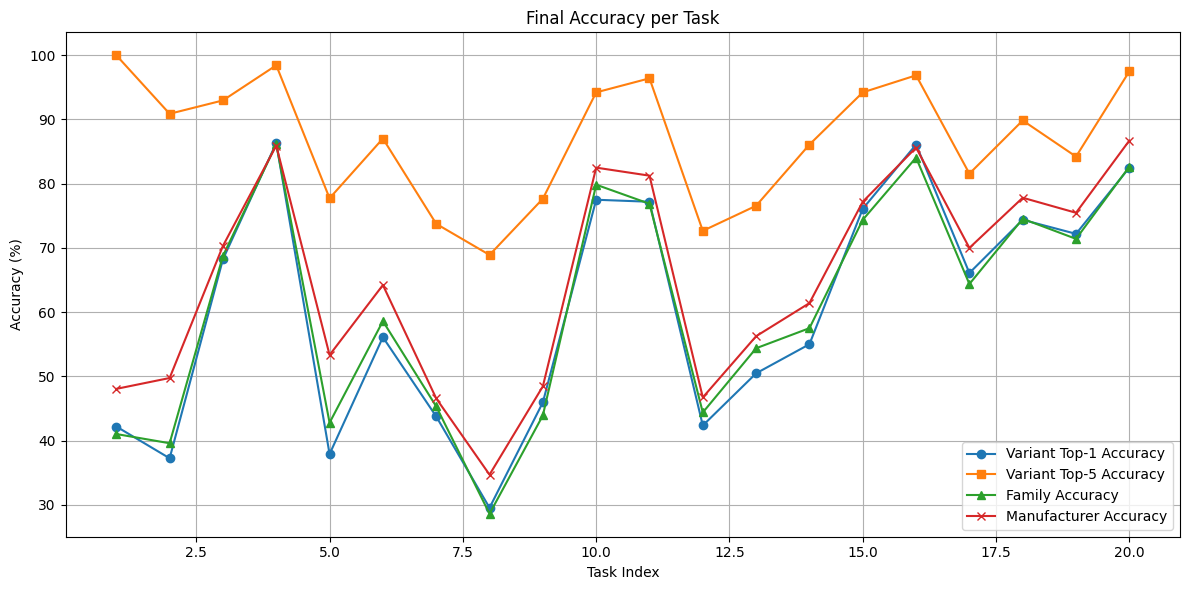

In [16]:
import json
import matplotlib.pyplot as plt
import os

# Directories
metrics_dir = '.'  # Change this if your JSONs are in a subfolder

# Prepare containers
combined_acc = {'acc1': [], 'acc5': [], 'family_acc1': [], 'manu_acc1': []}
combined_loss = {'sploss': [], 'fmloss': [], 'mfloss': []}
task_indices = []

# Load metrics from each task
for tidx in range(1, 21):
    fname = os.path.join(metrics_dir, f'metrics_task{tidx}.json')
    if not os.path.exists(fname):
        print(f"⚠️ metrics_task{tidx}.json not found. Skipping.")
        continue

    with open(fname, 'r') as f:
        metrics = json.load(f)

    # Append final epoch stats
    combined_acc['acc1'].append(metrics['acc1'][-1])
    combined_acc['acc5'].append(metrics['acc5'][-1])
    combined_acc['family_acc1'].append(metrics['family_acc1'][-1])
    combined_acc['manu_acc1'].append(metrics['manu_acc1'][-1])
    combined_loss['sploss'].append(metrics['sploss'][-1])
    combined_loss['fmloss'].append(metrics['fmloss'][-1])
    combined_loss['mfloss'].append(metrics['mfloss'][-1])
    task_indices.append(tidx)

# ✅ Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(task_indices, combined_acc['acc1'], label='Variant Top-1 Accuracy', marker='o')
plt.plot(task_indices, combined_acc['acc5'], label='Variant Top-5 Accuracy', marker='s')
plt.plot(task_indices, combined_acc['family_acc1'], label='Family Accuracy', marker='^')
plt.plot(task_indices, combined_acc['manu_acc1'], label='Manufacturer Accuracy', marker='x')
plt.title('Final Accuracy per Task')
plt.xlabel('Task Index')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_accuracy_curve.png")
plt.show()


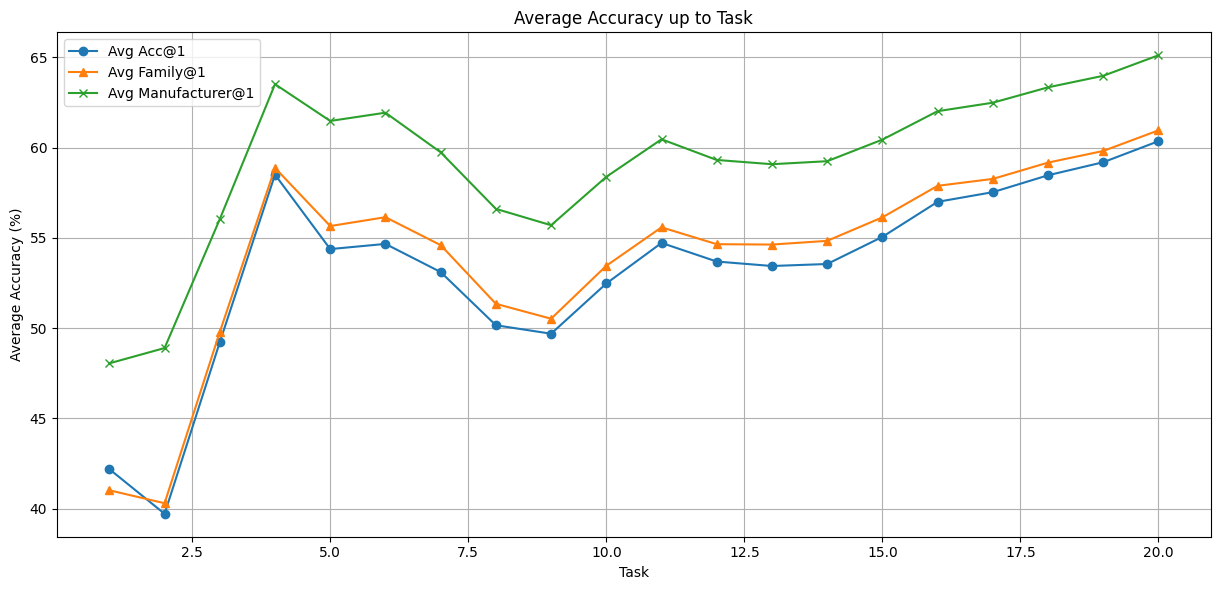

In [17]:
import json
import matplotlib.pyplot as plt
import os

# Directory where metric files are located
metrics_dir = '.'

# Initialize metric lists
acc1_list = []
acc5_list = []
fam_acc_list = []
manu_acc_list = []
sploss_list = []
fmloss_list = []
mfloss_list = []
task_indices = []

# Load metrics for each task
for tidx in range(1, 21):
    fname = os.path.join(metrics_dir, f'metrics_task{tidx}.json')
    if not os.path.exists(fname):
        print(f"⚠️ metrics_task{tidx}.json not found, skipping.")
        continue

    with open(fname, 'r') as f:
        metrics = json.load(f)

    acc1_list.append(metrics['acc1'][-1])
    acc5_list.append(metrics['acc5'][-1])
    fam_acc_list.append(metrics['family_acc1'][-1])
    manu_acc_list.append(metrics['manu_acc1'][-1])
    sploss_list.append(metrics['sploss'][-1])
    fmloss_list.append(metrics['fmloss'][-1])
    mfloss_list.append(metrics['mfloss'][-1])
    task_indices.append(tidx)

# Compute cumulative average accuracy
def cumulative_avg(lst):
    return [sum(lst[:i+1]) / (i+1) for i in range(len(lst))]

avg_acc1 = cumulative_avg(acc1_list)
avg_acc5 = cumulative_avg(acc5_list)
avg_fam = cumulative_avg(fam_acc_list)
avg_man = cumulative_avg(manu_acc_list)

# Plot results
plt.figure(figsize=(24, 6))

# Left: Final Accuracy per Task
# plt.subplot(1, 2, 1)
# plt.plot(task_indices, acc1_list, label='Acc@1', marker='o')
# plt.plot(task_indices, acc5_list, label='Acc@5', marker='s')
# plt.plot(task_indices, fam_acc_list, label='Family@1', marker='^')
# plt.plot(task_indices, manu_acc_list, label='Manufacturer@1', marker='x')
# plt.xlabel("Task")
# plt.ylabel("Final Accuracy (%)")
# plt.title("Final Accuracy per Task")
# plt.legend()
# plt.grid(True)

# Right: Cumulative Average Accuracy up to Task
plt.subplot(1, 2, 2)
plt.plot(task_indices, avg_acc1, label='Avg Acc@1', marker='o')
# plt.plot(task_indices, avg_acc5, label='Avg Acc@5', marker='s')
plt.plot(task_indices, avg_fam, label='Avg Family@1', marker='^')
plt.plot(task_indices, avg_man, label='Avg Manufacturer@1', marker='x')
plt.xlabel("Task")
plt.ylabel("Average Accuracy (%)")
plt.title("Average Accuracy up to Task")
plt.legend()
plt.grid(True)

# Save and show
plt.tight_layout()
plt.savefig("combined_accuracy_avg_plot.png")
plt.show()
